In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
path.ls()

In [ ]:
img_files = get_image_files(path)
def img2pose(x) : return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

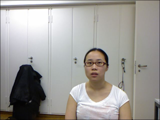

In [8]:
im = PILImage.create(img_files[0])
im.shape
im.to_thumb(160)

<Axes: >

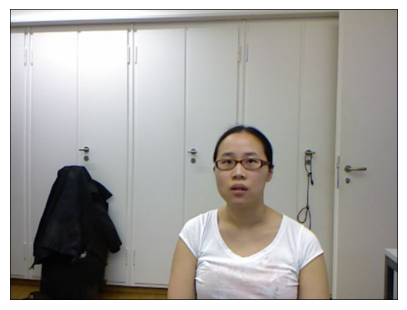

In [7]:
im.show()

In [9]:
t = img2pose(img_files[0])

In [11]:
t.read_text()

'0.986035 -0.0415048 0.161283 \n0.0173199 0.988752 0.148558 \n-0.165635 -0.14369 0.975663 \n\n111.179 35.4776 857.72 \n\n'

In [14]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
       ctr = np.genfromtxt(img2pose(f), skip_header=3)
       c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
       c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
       return tensor([c1,c2])

In [16]:
get_ctr(img_files[0])


tensor([387.1024, 261.9126])

In [25]:
biwi = DataBlock(
       blocks=(ImageBlock, PointBlock),
       get_items = get_image_files,
       get_y=get_ctr,
       splitter=FuncSplitter(lambda o: o.parent.name=='13'),
       batch_tfms=[*aug_transforms(size=(240,320)),
                   Normalize.from_stats(*imagenet_stats)]
)

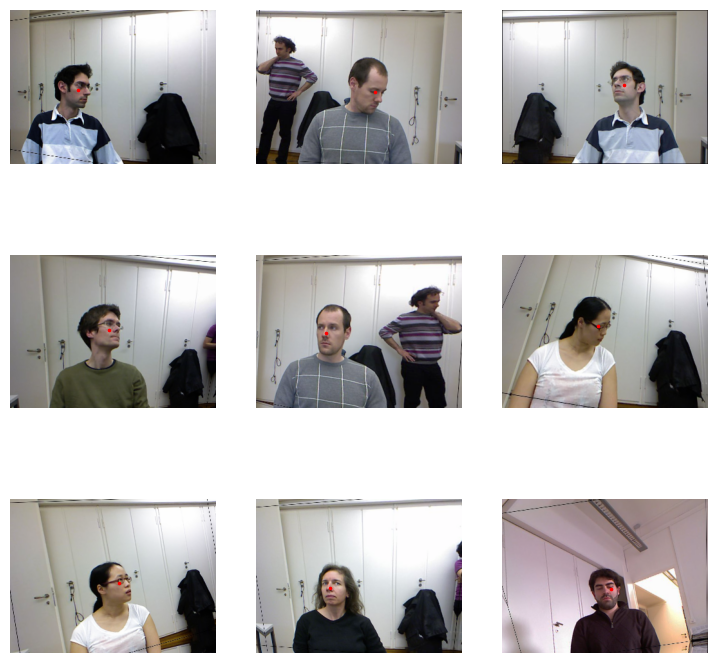

In [28]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9)

In [29]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [30]:
yb[0]

TensorPoint([[-0.0292, -0.2226]], device='mps:0')

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [34]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0008317637839354575)

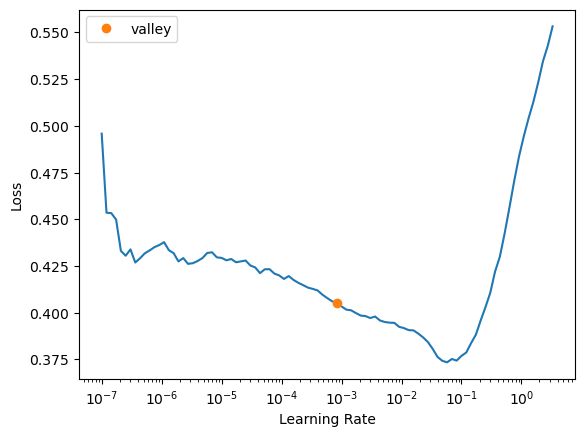

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.047945,0.017029,02:14
1,0.007351,0.002184,02:12
2,0.003312,0.000423,02:09
3,0.002421,0.000593,02:12
4,0.001769,0.000193,02:14


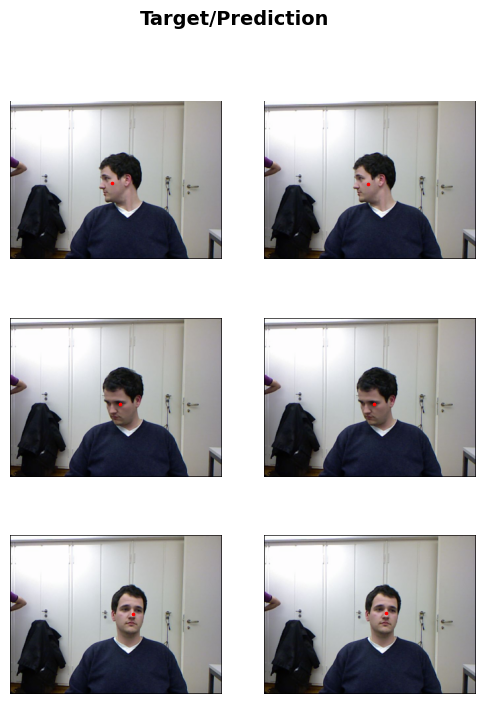

In [39]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))